In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**<h1><center>Twitter Sentimental Analysis</center></h1>**

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

**<h2>Contents</h2>**

- Importing Libraries

- Loading Data

- Lower Casing and Removing Punctuations, Numbers, Special Character.

- Removing Stop words

- Lemmatization

- Treating Imbalanced Dataset

- TF-IDF Vectorizer

- Model Training


**1. Importing Libraries**

Here we will import required libraries for preprocessing and  model training. We will use pandas and NLTK for text preprocessing, sklearn and XGboost for model training.

In [2]:
import pandas as pd
import numpy as np

import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import confusion_matrix,classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf

from xgboost import XGBClassifier

from sklearn.utils import resample

import seaborn as sns 

import pickle

nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

**2. Loading Dataset**

Here we will use pandas ```read_csv```  function to read csv files. The dataset is from analytics Vidhya (https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#ProblemStatement) 

In [3]:
# Reading input files

train_data = pd.read_csv("/content/drive/My Drive/Twitter Sentimental Analysis/\
Data Files/train.csv")

train_data.shape

(31962, 3)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


train_data has 31962 observation and 3 columns.Tweet is independent variable and label is  target variable.

In [5]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


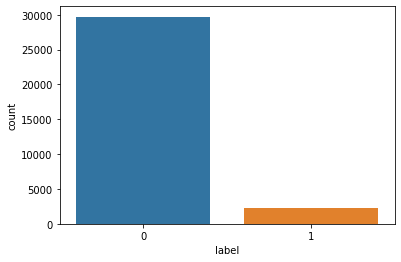

In [6]:
sns.countplot(train_data['label'])

**3. Lower Casing and Removing Punctuations, Numbers, Special Character.**

lower() is used to make string to lower case. And regular expression is used to remove unwanted characters.s

In [7]:
def lower_casing(sentence):
    """
    This function is used to convert string into 
    lower case
    Parameters
    ----------
      sentence : str
        input string
    Returns
    --------
      lower_cased_sentence : str
        Lower cased sentence
    """
    lower_cased_sentence = " ".join([word.lower() \
                                     for word in sentence.split()])
    return lower_cased_sentence


def remove_unwanted_char(sentence):
    """
    This function is to remove unwanted characters
    Parameters
    ----------
    sentence : str
      input string
    Returns
    --------
    processed_sentences : str
      processed string s
    """
    processed_sentences = " ".join([re.sub('[0-9]','digit', str(word)) \
                                    for word in sentence.split()])
    
    processed_sentences = " ".join([re.sub('[^a-zA-Z]','', str(word)) \
                                    for word in processed_sentences.split()])
    
    processed_sentences = " ".join([re.sub('[^a-zA-Z]','', str(word)) \
                                    for word in processed_sentences.split()])
    
    processed_sentences = " ".join([re.sub('user','', str(word)) \
                                    for word in processed_sentences.split()])
    
    processed_sentences = " ".join([re.sub('amp','', str(word)) \
                                    for word in processed_sentences.split()])
    
    return processed_sentences

**4. Removing the stopwords**

Stop words does not contain much information compared to other words. We will use NLTK library to remove stop words.

In [8]:
def remove_stop_words(sentences):
    """
    This function is to remove stop words
    Parameters
    ----------
    sentences : str
      input string
    Returns
    --------
    sentence_processed : str
      processed string s
    """
    stop = stopwords.words('english')
    sentence_processed =  " ".join(i for i in sentences.split() if i not in stop)
    return sentence_processed

**5. Lemmatization**

Lemmatization is used to get root words.

In [9]:
def get_root_words(sentences):
    """
    This function is to get root words
    Parameters
    ----------
    sentences : str
      input string
    Returns
    --------
    root_worded_sentence : str
      processed string 
    """
    lemmatizer = WordNetLemmatizer()
    root_worded_sentence = " ".join([lemmatizer.lemmatize(word) for word in sentences.split()])
    return root_worded_sentence

In [10]:
def text_preprocess(list_sentences):
  """
  This function helps to preprocess text
  Parameter
  ---------
    text : list()
      list of sentences
  Returns
  --------
    sentences : list()
      list of preprocessed sentences
  """
  try:
    processed_sentences = list()
    lemmatizer = WordNetLemmatizer()
    for sentence in list_sentences:
      sentence = lower_casing(sentence)
      sentence = remove_unwanted_char(sentence)
      sentence = remove_stop_words(sentence)
      sentence = get_root_words(sentence)
      processed_sentences.append(sentence)
    return processed_sentences
  except Exception as e:
    print(e)
    return list_sentences

train_data['tweet'] = text_preprocess(train_data['tweet'])


**6. Treating imbalanced dataset.**

We will use sklearn ```resample``` function to make balance dataset.

In [11]:
# Separate majority and minority classes
train_majority = train_data[train_data.label==0]
train_minority = train_data[train_data.label==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_data = pd.concat([train_majority, train_minority_upsampled])

**7. TF-IDF Vectorizer**

Converting textual data into numerical data. Here we will use TF-IDF Vectorizer to convert text into numerical.

In [12]:
X = train_data['tweet']
y = train_data['label']

tfidf = tf_idf(max_df=0.90, 
               min_df=2,
               max_features=10000, 
               stop_words='english')

X = tfidf.fit_transform(X).toarray()

with open("/content/drive/My Drive/Twitter Sentimental Analysis/\
Data Files/vectorizer.pkl", "wb") as f: 
    pickle.dump(tfidf, f)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=0)

**8. Model Training and Model selection**

Here we will load and train several algorithms and we will select best algorithm which gives best result in terms of accuracy and F1-score.




In [13]:
import pickle

folder_name = '/content/drive/My Drive/Twitter Sentimental Analysis/Data Files/'

prediction_data = {'Algorithm':[],
                   'Accuracy':[],
                   'F1 Score':[]
                   }


models = {'Logistic_Regression' : LogisticRegression(),
          "Random_forest": RandomForestClassifier(),
          "Gradient_boosting": GradientBoostingClassifier(),
          "Ada_boost": AdaBoostClassifier(),
          "KNN_algorithm": KNeighborsClassifier(),
          "Xg_boost" : XGBClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    result = model.score(X_test,y_test)

    file_path = folder_name + name + ".pkl" 
    pickle.dump(model, open(file_path, 'wb'))


    print("Accuracy of {} is {}".format(name, result))

    print("F1 score is {}".format(f1_score(y_test, pred)))
    prediction_data['Algorithm'].append(name)
    prediction_data['Accuracy'].append(result)
    prediction_data['F1 Score'].append(f1_score(y_test, pred))


prediction_data


Accuracy of Logistic_Regression is 0.9522658610271904
F1 score is 0.8998732572877061
Accuracy of Random_forest is 0.9853977844914401
F1 score is 0.9712472734483443
Accuracy of Gradient_boosting is 0.8529707955689829
F1 score is 0.6098343132014965
Accuracy of Ada_boost is 0.8560926485397784
F1 score is 0.6383194128068843
Accuracy of KNN_algorithm is 0.9556898288016112
F1 score is 0.9040139616055848
Accuracy of Xg_boost is 0.8444108761329305
F1 score is 0.5768282662284306


{'Algorithm': ['Logistic_Regression',
  'Random_forest',
  'Gradient_boosting',
  'Ada_boost',
  'KNN_algorithm',
  'Xg_boost'],
 'Accuracy': [0.9522658610271904,
  0.9853977844914401,
  0.8529707955689829,
  0.8560926485397784,
  0.9556898288016112,
  0.8444108761329305],
 'F1 Score': [0.8998732572877061,
  0.9712472734483443,
  0.6098343132014965,
  0.6383194128068843,
  0.9040139616055848,
  0.5768282662284306]}

In [14]:
prediction_data = pd.DataFrame(prediction_data)

prediction_data

,Algorithm,Accuracy,F1 Score
0,Logistic_Regression,0.952266,0.899873
1,Random_forest,0.985398,0.971247
2,Gradient_boosting,0.852971,0.609834
3,Ada_boost,0.856093,0.638319
4,KNN_algorithm,0.955690,0.904014
5,Xg_boost,0.844411,0.576828


In [ ]:
Random_forest = RandomForestClassifier()

Random_forest.fit(X_train, y_train)
pred = Random_forest.predict(X_test)


print("Accuracy is {}".format(Random_forest.score(X_test,y_test)))
print("F1 score is {}".format(f1_score(y_test, pred)))
print(classification_report(y_test, pred))